In [996]:
import os
import librosa
import librosa.display
import numpy as np

os.environ["TF_ENABLE_MLIR"] = "1"
os.environ["TF_GPU_THREAD_MODE"] = "gpu_private"
os.environ["TF_USE_LEGACY_GPU_KERNELS"] = "1"

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt

In [997]:
import subprocess
subprocess.run(["system_profiler", "SPDisplaysDataType"])

Graphics/Displays:

    Apple M4 Max:

      Chipset Model: Apple M4 Max
      Type: GPU
      Bus: Built-In
      Total Number of Cores: 40
      Vendor: Apple (0x106b)
      Metal Support: Metal 3
      Displays:
        LS34A650U:
          Resolution: 3440 x 1440 (UWQHD - Ultra-Wide Quad HD)
          UI Looks like: 3440 x 1440 @ 100.00Hz
          Main Display: Yes
          Mirror: Off
          Online: Yes
          Rotation: Supported



CompletedProcess(args=['system_profiler', 'SPDisplaysDataType'], returncode=0)

In [998]:
# Fixed spectrogram shape (H, W)
SPEC_HEIGHT = 128   # Mel filterbanks
SPEC_WIDTH = 344    # 344 # Ensures 5 seconds of time steps at 100 fps
AUDIO_LENGTH = 3    # Target audio length in seconds
SAMPLE_RATE = 16000  # 16kHz sample rate
F_MIN = 0
F_MAX = 1800
FIG_HEIGHT = SPEC_HEIGHT * 2
FIG_WIDTH = SPEC_WIDTH * 2

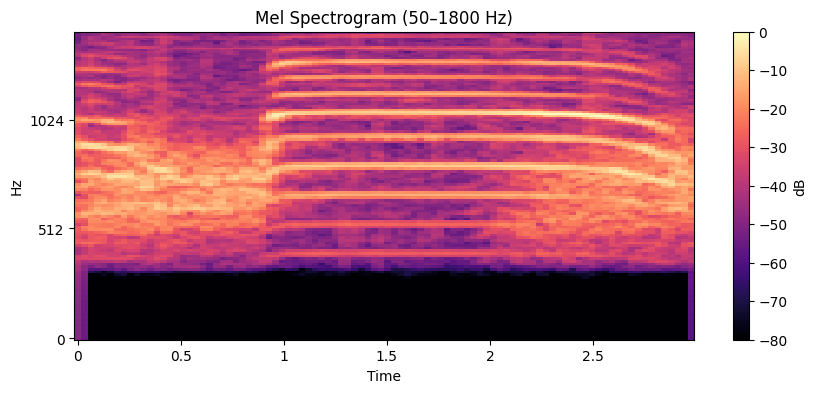

In [1000]:
# Let's check out the spectrogram to see how it looks
# file_path = "/Users/ec/Documents/Data/Frog-Call-Classifier/_data/Example/Parsed_Capuchinbird_Clips/XC433953-0.wav"
file_path = "/Users/ec/Documents/Data/Frog-Call-Classifier/_data/Example/Parsed_Capuchinbird_Clips/XC395129-5.wav"
wav, sr = librosa.load(file_path, sr=16000)

# Compute new Mel spectrogram
mel_spec = librosa.feature.melspectrogram(y=wav, sr=sr, n_mels=128, fmin=F_MIN, fmax=F_MAX)
mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

# Plot
plt.figure(figsize=(10, 4))
librosa.display.specshow(mel_spec_db, sr=sr, x_axis="time", y_axis="mel", fmin=F_MIN, fmax=F_MAX)
plt.colorbar(label="dB")
plt.title("Mel Spectrogram (50–1800 Hz)")
plt.show()

In [1007]:
SAMPLE_RATE = 16000  # 16kHz sampling rate
AUDIO_LENGTH = 3     # 5 seconds max
F_MIN, F_MAX = 50, 8000
SPEC_HEIGHT, SPEC_WIDTH = 128, 100  # Height (mel bands) and fixed width for 5 seconds
# SHAPE_HEIGHT, SHAPE_WIDTH = 257, 1491

def preprocess(file_path, label):
    # Handle both tensor and string inputs
    if isinstance(file_path, tf.Tensor):
        file_path = file_path.numpy().decode('utf-8')

    # Load audio file (16 kHz, mono)
    wav, sr = librosa.load(file_path, sr=SAMPLE_RATE)

    # Ensure 5 seconds (pad if shorter, trim if longer)
    target_length = SAMPLE_RATE * AUDIO_LENGTH
    wav = np.pad(wav[:target_length], (0, max(0, target_length - len(wav))), mode="constant")

    # Compute Mel spectrogram (50-800 Hz)
    mel_spec = librosa.feature.melspectrogram(
        y=wav, sr=sr, n_mels=SPEC_HEIGHT, fmin=F_MIN, fmax=F_MAX, hop_length=512
    )

    # Convert power to dB (ref=1.0 ensures negative dB values)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=1.0)
    
    # Zero pad to ensure uniform time length (500 frames)
    pad_width = [[0, 0], [0, max(0, SPEC_WIDTH - mel_spec_db.shape[1])]]
    mel_spec_db = np.pad(mel_spec_db, pad_width, mode='constant', constant_values=0)

    # Ensure a fixed size using resizing
    mel_spec_db = np.expand_dims(mel_spec_db, axis=-1)  # Add channel dim
    mel_spec_db = tf.image.resize(mel_spec_db, (SPEC_HEIGHT, SPEC_WIDTH))  # Resize
    mel_spec_db.set_shape((SPEC_HEIGHT, SPEC_WIDTH, 1))

    # Convert to TensorFlow tensor and normalize (excluding padded silence)
    mel_tensor = tf.convert_to_tensor(mel_spec_db, dtype=tf.float32)

    # Normalize only non-padded values
    non_silent_mask = tf.not_equal(mel_tensor, -80.0)
    valid_values = tf.boolean_mask(mel_tensor, non_silent_mask)
    mean, std = tf.reduce_mean(valid_values), tf.math.reduce_std(valid_values)

    # Apply normalization safely
    mel_tensor = (mel_tensor - mean) / (std + 1e-6)

    return mel_tensor, label


In [1001]:
SAMPLE_RATE = 16000  # 16kHz sampling rate
AUDIO_LENGTH = 3     # 5 seconds max
F_MIN, F_MAX = 50, 8000
SPEC_HEIGHT, SPEC_WIDTH = 128, 100  # Height (mel bands) and fixed width for 5 seconds
# SHAPE_HEIGHT, SHAPE_WIDTH = 257, 1491


def preprocess(file_path, label):
    # Convert to string if tensor
    if isinstance(file_path, tf.Tensor):
        file_path = file_path.numpy().decode('utf-8')

    # Load audio file (5s, 16 kHz)
    wav, sr = librosa.load(file_path, sr=SAMPLE_RATE)
    target_length = SAMPLE_RATE * AUDIO_LENGTH
    wav = np.pad(wav[:target_length], (0, max(0, target_length - len(wav))), mode="constant")

    # Generate Mel spectrogram
    mel_spec = librosa.feature.melspectrogram(
        y=wav, sr=sr, n_mels=SPEC_HEIGHT, hop_length=HOP_LENGTH, fmin=50, fmax=800
    )

    # Convert to dB and pad if needed
    mel_spec_db = librosa.power_to_db(mel_spec, ref=1.0)
    pad_width = [[0, 0], [0, max(0, SPEC_WIDTH - mel_spec_db.shape[1])]]
    mel_spec_db = np.pad(mel_spec_db, pad_width, mode="constant", constant_values=-80)

    # Convert to tensor and normalize
    mel_tensor = tf.convert_to_tensor(mel_spec_db, dtype=tf.float32)
    mel_tensor = (mel_tensor - tf.reduce_mean(mel_tensor)) / (tf.math.reduce_std(mel_tensor) + 1e-6)

    # Ensure fixed shape
    mel_tensor = tf.expand_dims(mel_tensor, axis=-1)
    mel_tensor.set_shape((SPEC_HEIGHT, SPEC_WIDTH, 1))

    return mel_tensor, label


In [1008]:
# Apply function within a TensorFlow Dataset
def load_and_preprocess(file_path, label):
    spectrogram, label = tf.py_function(preprocess, [file_path, label], [tf.float32, tf.int32])
    spectrogram.set_shape((SPEC_HEIGHT, SPEC_WIDTH, 1))  # Ensure fixed shape
    return spectrogram, label

In [1009]:
wd = os.getcwd().replace("/_scripts","")
POS = os.path.join(wd,'_data','Example', 'Parsed_Capuchinbird_Clips', '*.wav')
NEG = os.path.join(wd,'_data','Example','Parsed_Not_Capuchinbird_Clips', '*.wav')

# Load file paths
pos_files = tf.data.Dataset.list_files(POS, shuffle=False)
neg_files = tf.data.Dataset.list_files(NEG, shuffle=False)

# Check if files are loaded
print(f"Positive samples: {len(list(pos_files))}")
print(f"Negative samples: {len(list(neg_files))}")

Positive samples: 217
Negative samples: 593


2025-02-21 15:56:33.852333: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-02-21 15:56:33.868666: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [1010]:
# Function to load each file and get its duration
def get_audio_duration(file_path):
    # Convert tensor to string for file path
    file_path = file_path.numpy().decode('utf-8')
    # Load audio and calculate duration
    wav, sr = librosa.load(file_path, sr=None)
    duration = len(wav) / sr
    return duration

# Wrap in tf.py_function to work with tf.data.Dataset
def tf_get_audio_duration(file_path):
    return tf.py_function(get_audio_duration, [file_path], tf.float32)

# Apply function to dataset and collect durations
durations = pos_files.map(tf_get_audio_duration)

# Convert dataset to a list of durations
durations_list = list(durations.as_numpy_iterator())

# Calculate min, max, and average duration
min_duration = min(durations_list)
max_duration = max(durations_list)
avg_duration = sum(durations_list) / len(durations_list)

# Display results
print(f"Minimum duration: {min_duration:.2f} seconds")
print(f"Maximum duration: {max_duration:.2f} seconds")
print(f"Average duration: {avg_duration:.2f} seconds")


Minimum duration: 2.00 seconds
Maximum duration: 5.00 seconds
Average duration: 3.38 seconds


2025-02-21 15:56:35.625667: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


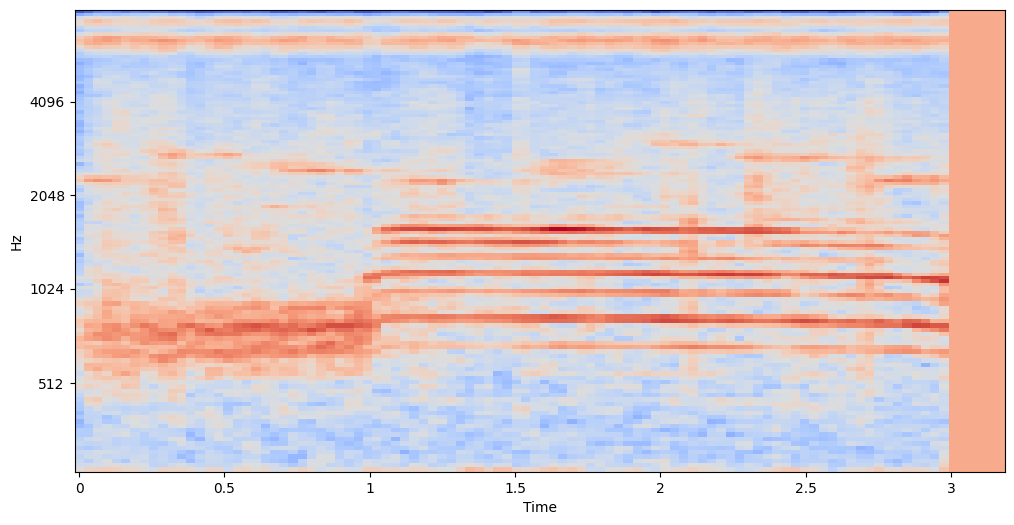

In [1023]:
def plot_spectrogram(spectrogram, sr=SAMPLE_RATE):
    plt.figure(figsize=(12, 6))
    librosa.display.specshow(spectrogram.numpy().squeeze(), sr=sr, hop_length=512, x_axis='time', y_axis='mel', fmin=50)#, fmax=16000)
    # plt.colorbar(format="%+2.0f dB")
    # plt.title("Mel Spectrogram (50–800 Hz)")
    plt.show()

# Shuffle to randomize order
shuffled_files = pos_files.shuffle(buffer_size=100)
file_path = next(iter(shuffled_files)).numpy().decode('utf-8')

# Test with one sample
mel_spec, _ = preprocess(file_path, 1)
plot_spectrogram(mel_spec)

In [1024]:
# Apply preprocessing
positives = pos_files.map(lambda x: load_and_preprocess(x, 1))
negatives = neg_files.map(lambda x: load_and_preprocess(x, 0))

# Combine datasets
data = positives.concatenate(negatives)

In [1025]:
# reshape the data
data = data.map(lambda x, y: (x, tf.reshape(y, [-1])))


In [1026]:
# Split into training (80%) and testing (20%)
dataset_size = len(list(data))  # Count dataset size
test_size = int(0.2 * dataset_size)  # 20% test
train_size = dataset_size - test_size  # 80% train

# Take the first 80% as training data
train_data = data.take(train_size)

# Skip the first 80% and take the remaining 20% as test data
test_data = data.skip(train_size)

# Shuffle, batch, and prefetch
train_data = train_data.shuffle(1000).batch(16, drop_remainder=True).prefetch(tf.data.AUTOTUNE)
test_data = test_data.batch(16, drop_remainder=True).prefetch(tf.data.AUTOTUNE)  # No shuffle for test set

2025-02-21 15:57:34.380561: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [80]:
# Shuffle, batch, and prefetch
# data = data.shuffle(1000).batch(16, drop_remainder=True).prefetch(tf.data.AUTOTUNE)

In [1027]:
dataset_size = sum(1 for _ in data)
print(f"Final dataset size: {dataset_size}")

dataset_size_train = sum(1 for _ in train_data)
print(f"Training dataset size: {dataset_size_train}")

dataset_size_test = sum(1 for _ in test_data)
print(f"Testing dataset size: {dataset_size_test}")

2025-02-21 15:58:06.184912: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Final dataset size: 810


2025-02-21 15:58:24.399664: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Training dataset size: 40
Testing dataset size: 10


2025-02-21 15:58:44.977595: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [1028]:
for sample_wav, sample_label in train_data.take(1):
    print("Waveform shape:", sample_wav.shape) # Expected: (16, 128, 344, 1)
    print("Label shape:", sample_label.shape) # Expected: (16,)
    print("Label values:", sample_label.numpy())

Waveform shape: (16, 128, 100, 1)
Label shape: (16, 1)
Label values: [[1]
 [0]
 [1]
 [0]
 [1]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [0]]


2025-02-21 15:59:21.181382: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [1029]:
# Define CNN Model
def build_model():
    model = models.Sequential([
    # Input layer
    layers.Input(shape=(SPEC_HEIGHT, SPEC_WIDTH, 1)),

    # Convolutional layers
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    # Flatten and Dense layers
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),  # Prevent overfitting
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),

    # Output layer
    layers.Dense(1, activation='sigmoid')
    
    ])
    model.compile(optimizer=Adam(learning_rate=0.0001), 
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    return model

model = build_model()
model.summary()


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_21 (Conv2D)              │ (None, 128, 100, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_21          │ (None, 128, 100, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 64, 50, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 64, 50, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_22          │ (None, 64, 50, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 32, 25, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 32, 25, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_23          │ (None, 32, 25, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (None, 16, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 24576)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 256)            │     6,291,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,401,793 (24.42 MB)

 Trainable params: 6,401,345 (24.42 MB)

 Non-trainable params: 448 (1.75 KB)

In [1030]:
print(f"Model expects: {model.input_shape}")


Model expects: (None, 128, 100, 1)


In [1031]:
# Train the model
# early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(train_data, validation_data = test_data, epochs=5) #, callbacks=[early_stopping]) # 18

Epoch 1/5
40/40 ━━━━━━━━━━━━━━━━━━━━ 41s 566ms/step - accuracy: 0.8540 - loss: 0.7762 - val_accuracy: 1.0000 - val_loss: 0.0840
Epoch 2/5
40/40 ━━━━━━━━━━━━━━━━━━━━ 37s 521ms/step - accuracy: 0.9702 - loss: 0.3147 - val_accuracy: 1.0000 - val_loss: 0.0055
Epoch 3/5
40/40 ━━━━━━━━━━━━━━━━━━━━ 35s 519ms/step - accuracy: 0.9811 - loss: 0.3037 - val_accuracy: 1.0000 - val_loss: 0.0049
Epoch 4/5
40/40 ━━━━━━━━━━━━━━━━━━━━ 36s 522ms/step - accuracy: 0.9933 - loss: 0.0557 - val_accuracy: 1.0000 - val_loss: 4.1356e-04
Epoch 5/5
40/40 ━━━━━━━━━━━━━━━━━━━━ 38s 531ms/step - accuracy: 0.9901 - loss: 0.0820 - val_accuracy: 1.0000 - val_loss: 1.5401e-04


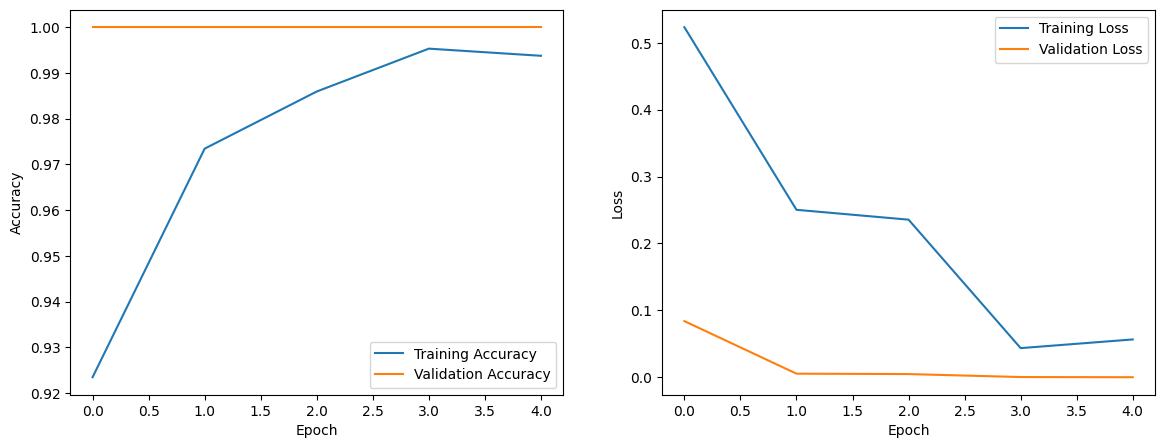

In [1032]:
def plot_history(history):
    plt.figure(figsize=(14, 5))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    if 'val_accuracy' in history.history:
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    if 'val_loss' in history.history:
        plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

plot_history(history)

In [1033]:
final_loss = history.history['loss'][-1]
final_accuracy = history.history['accuracy'][-1]
print(f"Final Training Loss: {final_loss:.4f}")
print(f"Final Training Accuracy: {final_accuracy:.4f}")


Final Training Loss: 0.0566
Final Training Accuracy: 0.9937


In [1034]:
test_loss, test_acc = model.evaluate(test_data)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

10/10 ━━━━━━━━━━━━━━━━━━━━ 22s 446ms/step - accuracy: 1.0000 - loss: 5.8706e-05
Test Loss: 0.0002
Test Accuracy: 1.0000


In [1035]:
sample_batch = next(iter(test_data.take(1)))  # Get one batch from test data
sample_spectrograms, sample_labels = sample_batch

predictions = model.predict(sample_spectrograms)
predictions = (predictions > 0.5).astype(int)  # Convert probabilities to binary labels

print("Predicted Labels:", predictions.flatten())
print("Actual Labels:   ", sample_labels.numpy().flatten())

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step
Predicted Labels: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Actual Labels:    [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [1036]:
# Path to the 30-minute audio file
audio_path = "/Users/ec/Documents/Data/Frog-Call-Classifier/_data/Example/Forest Recordings/recording_87.mp3"

# Load the full audio file
wav, sr = librosa.load(audio_path, sr=16000)  # Ensure 16kHz sample rate

# Define the window size (3 seconds * 16000 samples per second)
window_size = sr * 5

# Split into 3-second clips
clips = [wav[i : i + window_size] for i in range(0, len(wav), window_size)]

# Remove the last clip if it's less than 3 seconds
clips = [clip for clip in clips if len(clip) == window_size]

print(f"Total 3-second clips created: {len(clips)}")

Total 3-second clips created: 36


In [1037]:
# Function to convert waveform to spectrogram
def waveform_to_spectrogram(wav):
    mel_spec = librosa.feature.melspectrogram(y=wav, sr=16000, n_mels=128)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    mel_spec_db = np.expand_dims(mel_spec_db, axis=-1)  # Add channel dimension
    mel_spec_db = tf.image.resize(mel_spec_db, (128, 100))  # Match model input
    mel_spec_db = (mel_spec_db - tf.reduce_mean(mel_spec_db)) / tf.math.reduce_std(mel_spec_db)
    return mel_spec_db

# Process each clip into a spectrogram
spectrograms = np.array([waveform_to_spectrogram(clip) for clip in clips])

print(f"Shape of spectrogram dataset: {spectrograms.shape}")

Shape of spectrogram dataset: (36, 128, 100, 1)


In [1039]:
# Predict using the model
predictions = model.predict(spectrograms)

# Apply threshold (if binary classification)
threshold = 0.5
predicted_labels = (predictions > threshold).astype(int)

# Output results
for i, label in enumerate(predicted_labels):
    start_time = i * 5
    end_time = start_time + 5
    print(f"Clip {i+1}: {start_time:02d}s - {end_time:02d}s → Prediction: {label}")

print(np.sum(predicted_labels))


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Clip 1: 00s - 05s → Prediction: [1]
Clip 2: 05s - 10s → Prediction: [0]
Clip 3: 10s - 15s → Prediction: [1]
Clip 4: 15s - 20s → Prediction: [1]
Clip 5: 20s - 25s → Prediction: [0]
Clip 6: 25s - 30s → Prediction: [0]
Clip 7: 30s - 35s → Prediction: [1]
Clip 8: 35s - 40s → Prediction: [1]
Clip 9: 40s - 45s → Prediction: [0]
Clip 10: 45s - 50s → Prediction: [1]
Clip 11: 50s - 55s → Prediction: [1]
Clip 12: 55s - 60s → Prediction: [0]
Clip 13: 60s - 65s → Prediction: [0]
Clip 14: 65s - 70s → Prediction: [1]
Clip 15: 70s - 75s → Prediction: [1]
Clip 16: 75s - 80s → Prediction: [0]
Clip 17: 80s - 85s → Prediction: [1]
Clip 18: 85s - 90s → Prediction: [1]
Clip 19: 90s - 95s → Prediction: [0]
Clip 20: 95s - 100s → Prediction: [1]
Clip 21: 100s - 105s → Prediction: [1]
Clip 22: 105s - 110s → Prediction: [0]
Clip 23: 110s - 115s → Prediction: [0]
Clip 24: 115s - 120s → Prediction: [1]
Clip 25: 120s - 125s → Prediction: [1]
Clip 26: 125s - 130s → Prediction: 

In [1040]:
# Constants
SPEC_HEIGHT = 128
SPEC_WIDTH = 100
SR = 16000  # Sample rate (16 kHz)
CLIP_DURATION = 5  # Duration per clip (seconds)
WINDOW_SIZE = SR * CLIP_DURATION  # 3 seconds * 16000 samples per second

def preprocess_audio(wav):
    """Convert waveform to Mel spectrogram with zero-padding and normalization."""
    # Ensure consistent length (3 seconds)
    wav = librosa.util.fix_length(wav, size=WINDOW_SIZE)

    # Filter frequency range (50 to 800 Hz)
    mel_spec = librosa.feature.melspectrogram(y=wav, sr=SR, n_mels=SPEC_HEIGHT, fmin=F_MIN, fmax=F_MAX)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

    # Add channel dimension and resize
    mel_spec_db = np.expand_dims(mel_spec_db, axis=-1)
    mel_spec_db = tf.image.resize(mel_spec_db, (SPEC_HEIGHT, SPEC_WIDTH))

    # Normalize (zero mean, unit variance)
    mel_spec_db = (mel_spec_db - np.mean(mel_spec_db)) / np.std(mel_spec_db)

    return mel_spec_db

In [1041]:
def split_audio(file_path):
    """Load and split audio into 3-second clips."""
    wav, _ = librosa.load(file_path, sr=SR)  # Load entire audio file

    # Split into 3-second windows
    clips = [wav[i:i + WINDOW_SIZE] for i in range(0, len(wav), WINDOW_SIZE)]

    # Only keep full 3-second clips
    clips = [clip for clip in clips if len(clip) == WINDOW_SIZE]

    print(f"Total 3-second clips generated: {len(clips)}")
    return clips


In [1042]:
def predict_clips(file_path):
    """Predict presence of target call in 3-second clips."""
    clips = split_audio(file_path)
    spectrograms = np.array([preprocess_audio(clip) for clip in clips])

    # Ensure correct shape for model input
    spectrograms = np.reshape(spectrograms, (-1, SPEC_HEIGHT, SPEC_WIDTH, 1))

    # Predict
    predictions = model.predict(spectrograms)
    predicted_labels = (predictions > 0.5).astype(int)

    # Display results
    for i, label in enumerate(predicted_labels):
        start_time = i * CLIP_DURATION
        end_time = start_time + CLIP_DURATION
        print(f"Clip {i+1}: {start_time:02d}s - {end_time:02d}s → Prediction: {label[0]}")

    return predicted_labels

In [1043]:
x = predict_clips(audio_path)

np.sum(x)

Total 3-second clips generated: 36
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Clip 1: 00s - 05s → Prediction: 1
Clip 2: 05s - 10s → Prediction: 0
Clip 3: 10s - 15s → Prediction: 1
Clip 4: 15s - 20s → Prediction: 1
Clip 5: 20s - 25s → Prediction: 0
Clip 6: 25s - 30s → Prediction: 0
Clip 7: 30s - 35s → Prediction: 1
Clip 8: 35s - 40s → Prediction: 1
Clip 9: 40s - 45s → Prediction: 0
Clip 10: 45s - 50s → Prediction: 1
Clip 11: 50s - 55s → Prediction: 1
Clip 12: 55s - 60s → Prediction: 0
Clip 13: 60s - 65s → Prediction: 0
Clip 14: 65s - 70s → Prediction: 1
Clip 15: 70s - 75s → Prediction: 1
Clip 16: 75s - 80s → Prediction: 0
Clip 17: 80s - 85s → Prediction: 1
Clip 18: 85s - 90s → Prediction: 1
Clip 19: 90s - 95s → Prediction: 0
Clip 20: 95s - 100s → Prediction: 1
Clip 21: 100s - 105s → Prediction: 1
Clip 22: 105s - 110s → Prediction: 0
Clip 23: 110s - 115s → Prediction: 0
Clip 24: 115s - 120s → Prediction: 1
Clip 25: 120s - 125s → Prediction: 1
Clip 26: 125s - 130s → Prediction: 0
Clip 27: 130s

21